In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict

In [2]:
### UTILITY FUNCTION FOR DATA GENERATION ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    
    return y


def gen_randomwalk(timesteps, noise):

    y = np.random.normal(0,noise, (timesteps,))
    
    return y.cumsum()

In [3]:
### CREATE SYNTHETIC DATA ###

np.random.seed(0)

timesteps = 1000

data1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=5)
data2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=5)
data3 = gen_randomwalk(timesteps=timesteps, noise=1)

# STATIONARY DATA

In [4]:
### STORE DATA IN DF ###

data = data1 + data2

df = pd.DataFrame({
    'X1':data1,
    'X2':data2,
    'Y':data
})

df.index = pd.date_range('2021', periods=timesteps, freq='H')
cols = df.columns

print(df.shape)
df.head()

(1000, 3)


,X1,X2,Y
2021-01-01 00:00:00,8.820262,2.779813,11.600075
2021-01-01 01:00:00,4.588976,4.836281,9.425258
2021-01-01 02:00:00,9.893690,-1.364273,8.529417
2021-01-01 03:00:00,18.275534,1.643215,19.918749
2021-01-01 04:00:00,17.998044,2.630689,20.628733


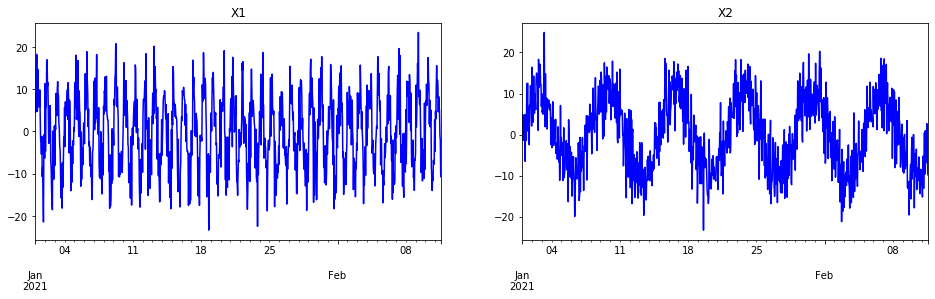

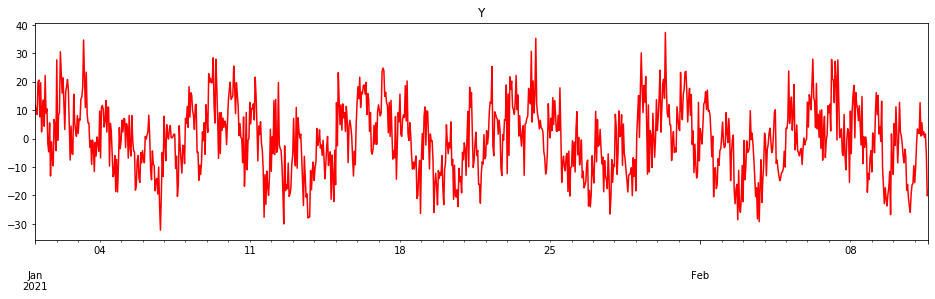

In [5]:
### PLOT SYNTHETIC DATA ###

plt.figure(figsize=(16,4))

for i,c in enumerate(cols[:-1]):
        
    plt.subplot(1,2,i+1)
    df[c].plot(ax=plt.gca(), title=c, color='blue'); plt.xlabel(None)

plt.figure(figsize=(16,4))
df['Y'].plot(title='Y', color='red')

In [6]:
### CREATE ROLLING FEATURES ###

lags = [6, 12, 18, 24]

for l in lags:
    for c in cols:
        df[f"{c}_mean_t-{l}"] = df[c].rolling(l).mean()
        df[f"{c}_std_t-{l}"] = df[c].rolling(l).std()

df['Y'] = df['Y'].shift(-1)
df.drop(cols[cols.str.startswith('X')], axis=1, inplace=True)
df.dropna(inplace=True)

In [7]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Y', axis=1), df['Y'], 
    test_size=24*7*2, shuffle=False)

X_train.shape, X_test.shape

((640, 24), (336, 24))

In [8]:
### RANDOM FOREST TUNING ###

model = GridSearchCV(estimator=RandomForestRegressor(random_state=33), 
                     param_grid={'max_depth': [8, 10, 12, None], 'n_estimators': [20, 30, 40]}, 
                     scoring='neg_mean_squared_error', cv=3, refit=True)
model.fit(X_train, y_train)

model.best_params_

{'max_depth': None, 'n_estimators': 40}

In [9]:
### OUT-OF-FOLDS RESIDUAL DISTRIBUTION ###

pred_train = cross_val_predict(RandomForestRegressor(**model.best_params_, random_state=33), 
                               X_train, y_train, cv=3)

res = y_train - pred_train

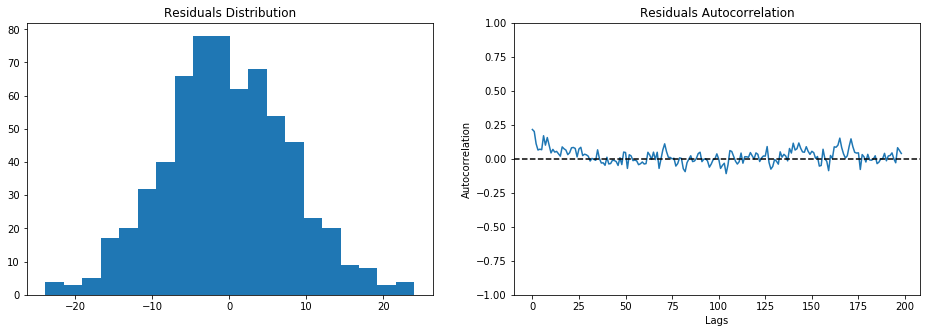

In [10]:
### PLOT RESIDUAL STATISTICS ###

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.title('Residuals Distribution')
plt.hist(res, bins=20)

plt.subplot(1,2,2)
plt.title('Residuals Autocorrelation')
plt.plot([res.autocorr(lag=dt) for dt in range(1,200)])
plt.ylim([-1,1]); plt.axhline(0, c='black', linestyle='--')
plt.ylabel('Autocorrelation'); plt.xlabel('Lags')

plt.show()

In [11]:
### BOOTSTRAPPED INTERVALS ###

alpha = 0.05

bootstrap = np.asarray([np.random.choice(res, size=res.shape) for _ in range(100)])
q_bootstrap = np.quantile(bootstrap, q=[alpha/2, 1-alpha/2], axis=0)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_lower = y_pred + q_bootstrap[0].mean()
y_upper = y_pred + q_bootstrap[1].mean()

Text(0.5, 1.0, 'RandomForest test predictions')

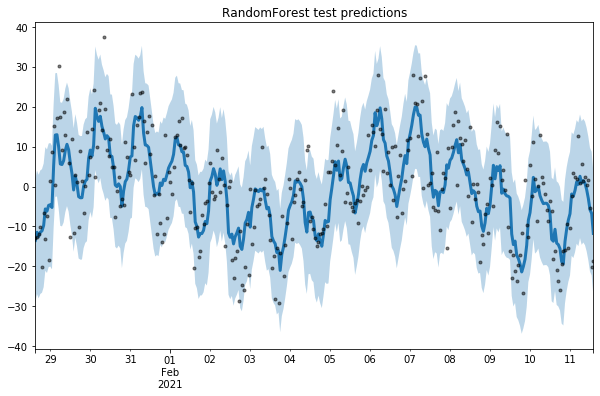

In [12]:
### PLOT BOOTSTRAPPED PREDICTION INTERVALS ###

plt.figure(figsize=(10,6))

y_pred.plot(linewidth=3)
y_test.plot(style='.k', alpha=0.5)
plt.fill_between(y_pred.index, y_lower, y_upper, alpha=0.3)
plt.title('RandomForest test predictions')

In [13]:
### HOW MANY OUTLIERS IN TEST DATA ###

((y_test > y_upper).sum() + (y_test < y_lower).sum()) / y_test.shape[0]

0.047619047619047616

In [14]:
### RIDGE TUNING ###

model = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [3, 5, 10, 20, 50]}, 
                     scoring='neg_mean_squared_error', cv=3, refit=True)
model.fit(X_train, y_train)

model.best_params_

{'alpha': 50}

In [15]:
### OUT-OF-FOLDS RESIDUAL DISTRIBUTION ###

pred_train = cross_val_predict(Ridge(**model.best_params_), X_train, y_train, cv=3)

res = y_train - pred_train

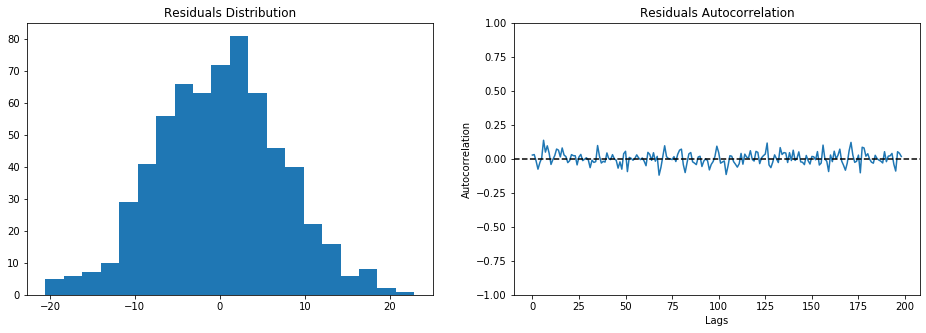

In [16]:
### PLOT RESIDUAL STATISTICS ###

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.title('Residuals Distribution')
plt.hist(res, bins=20)

plt.subplot(1,2,2)
plt.title('Residuals Autocorrelation')
plt.plot([res.autocorr(lag=dt) for dt in range(1,200)])
plt.ylim([-1,1]); plt.axhline(0, c='black', linestyle='--')
plt.ylabel('Autocorrelation'); plt.xlabel('Lags')

plt.show()

In [17]:
### BOOTSTRAPPED INTERVALS ###

alpha = 0.05

bootstrap = np.asarray([np.random.choice(res, size=res.shape) for _ in range(100)])
q_bootstrap = np.quantile(bootstrap, q=[alpha/2, 1-alpha/2], axis=0)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_lower = y_pred + q_bootstrap[0].mean()
y_upper = y_pred + q_bootstrap[1].mean()

Text(0.5, 1.0, 'Ridge test predictions')

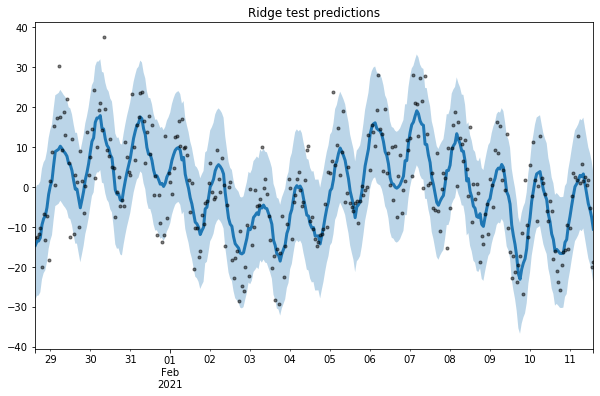

In [18]:
### PLOT BOOTSTRAPPED PREDICTION INTERVALS ###

plt.figure(figsize=(10,6))

y_pred.plot(linewidth=3)
y_test.plot(style='.k', alpha=0.5)
plt.fill_between(y_pred.index, y_lower, y_upper, alpha=0.3)
plt.title('Ridge test predictions')

In [19]:
### HOW MANY OUTLIERS IN TEST DATA ###

((y_test > y_upper).sum() + (y_test < y_lower).sum()) / y_test.shape[0]

0.05952380952380952

# NOT STATIONARY DATA

In [20]:
### STORE DATA IN DF ###

data = data1 + data2 + data3

df = pd.DataFrame({
    'X1':data1,
    'X2':data2,
    'X3':data3,
    'Y':data
})

df.index = pd.date_range('2021', periods=timesteps, freq='H')
cols = df.columns

print(df.shape)
df.head()

(1000, 4)


,X1,X2,X3,Y
2021-01-01 00:00:00,8.820262,2.779813,-1.532921,10.067154
2021-01-01 01:00:00,4.588976,4.836281,-3.244891,6.180367
2021-01-01 02:00:00,9.893690,-1.364273,-3.198756,5.330661
2021-01-01 03:00:00,18.275534,1.643215,-4.157131,15.761618
2021-01-01 04:00:00,17.998044,2.630689,-4.237942,16.390791


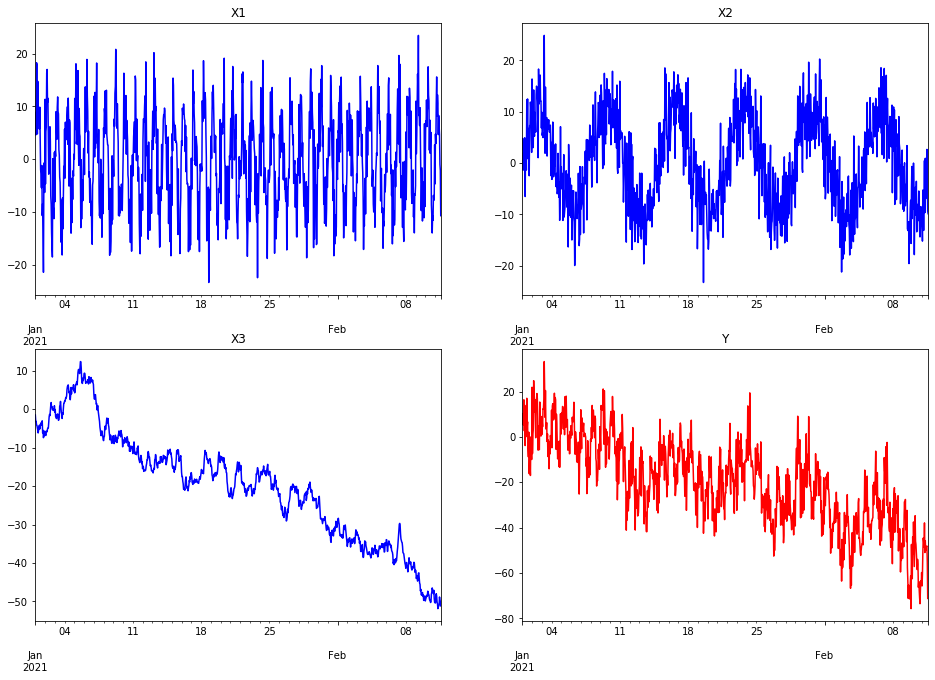

In [21]:
### PLOT SYNTHETIC DATA ###

plt.figure(figsize=(16,11))

for i,c in enumerate(cols):
    
    color = 'red' if c == 'Y' else 'blue'
    
    plt.subplot(2,2,i+1)
    df[c].plot(ax=plt.gca(), title=c, color=color); plt.xlabel(None)

In [22]:
### CREATE ROLLING FEATURES ###

lags = [6, 12, 18, 24]

for l in lags:
    for c in cols:
        df[f"{c}_mean_t-{l}"] = df[c].rolling(l).mean()
        df[f"{c}_std_t-{l}"] = df[c].rolling(l).std()

df['Y'] = df['Y'].shift(-1)
df.drop(cols[cols.str.startswith('X')], axis=1, inplace=True)
df.dropna(inplace=True)

In [23]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Y', axis=1), df['Y'], 
    test_size=24*7*2, shuffle=False)

X_train.shape, X_test.shape

((640, 32), (336, 32))

In [24]:
### RANDOM FOREST TUNING ###

model = GridSearchCV(estimator=RandomForestRegressor(random_state=33), 
                     param_grid={'max_depth': [8, 10, 12, None], 'n_estimators': [20, 30, 40]}, 
                     scoring='neg_mean_squared_error', cv=3, refit=True)
model.fit(X_train, y_train)

model.best_params_

{'max_depth': 8, 'n_estimators': 30}

In [25]:
### OUT-OF-FOLDS RESIDUAL DISTRIBUTION ###

pred_train = cross_val_predict(RandomForestRegressor(**model.best_params_, random_state=33), 
                               X_train, y_train, cv=3)

res = y_train - pred_train

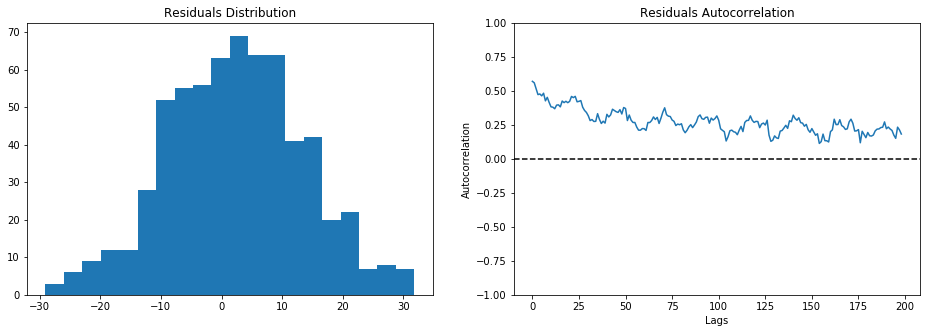

In [26]:
### PLOT RESIDUAL STATISTICS ###

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.title('Residuals Distribution')
plt.hist(res, bins=20)

plt.subplot(1,2,2)
plt.title('Residuals Autocorrelation')
plt.plot([res.autocorr(lag=dt) for dt in range(1,200)])
plt.ylim([-1,1]); plt.axhline(0, c='black', linestyle='--')
plt.ylabel('Autocorrelation'); plt.xlabel('Lags')

plt.show()

In [27]:
### BOOTSTRAPPED INTERVALS ###

alpha = 0.05

bootstrap = np.asarray([np.random.choice(res, size=res.shape) for _ in range(100)])
q_bootstrap = np.quantile(bootstrap, q=[alpha/2, 1-alpha/2], axis=0)

y_pred = model.predict(X_test)
y_lower = y_pred + q_bootstrap[0].mean()
y_upper = y_pred + q_bootstrap[1].mean()

In [28]:
### HOW MANY OUTLIERS IN TEST DATA ###

((y_test > y_upper).sum() + (y_test < y_lower).sum()) / y_test.shape[0]

0.125

In [29]:
### RIDGE TUNING ###

model = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [3, 5, 10, 20, 50]}, 
                     scoring='neg_mean_squared_error', cv=3, refit=True)
model.fit(X_train, y_train)

model.best_params_

{'alpha': 50}

In [30]:
### OUT-OF-FOLDS RESIDUAL DISTRIBUTION ###

pred_train = cross_val_predict(Ridge(**model.best_params_), X_train, y_train, cv=3)

res = y_train - pred_train

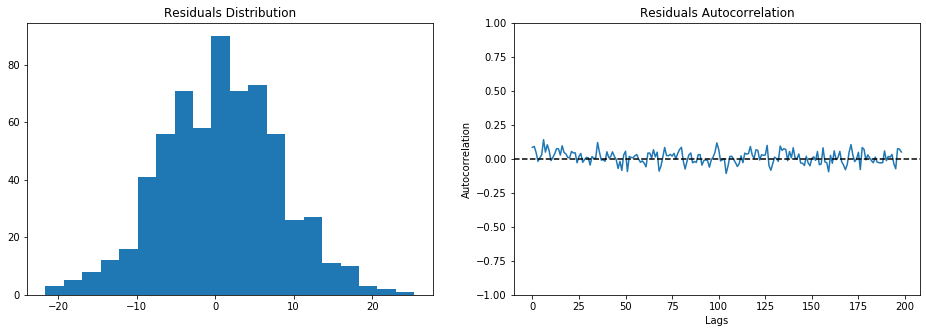

In [31]:
### PLOT RESIDUAL STATISTICS ###

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.title('Residuals Distribution')
plt.hist(res, bins=20)

plt.subplot(1,2,2)
plt.title('Residuals Autocorrelation')
plt.plot([res.autocorr(lag=dt) for dt in range(1,200)])
plt.ylim([-1,1]); plt.axhline(0, c='black', linestyle='--')
plt.ylabel('Autocorrelation'); plt.xlabel('Lags')

plt.show()

In [32]:
### BOOTSTRAPPED INTERVALS ###

alpha = 0.05

bootstrap = np.asarray([np.random.choice(res, size=res.shape) for _ in range(100)])
q_bootstrap = np.quantile(bootstrap, q=[alpha/2, 1-alpha/2], axis=0)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_lower = y_pred + q_bootstrap[0].mean()
y_upper = y_pred + q_bootstrap[1].mean()

Text(0.5, 1.0, 'Ridge test predictions')

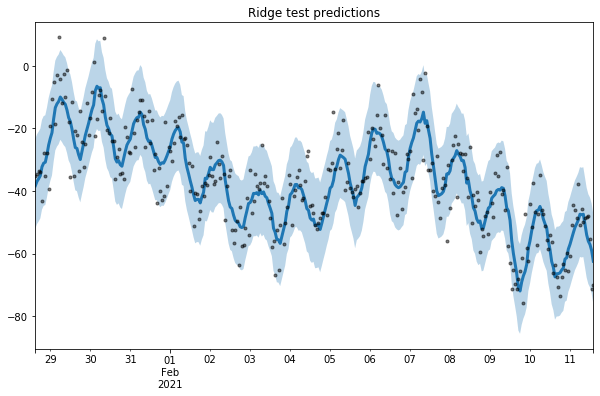

In [33]:
### PLOT BOOTSTRAPPED PREDICTION INTERVALS ###

plt.figure(figsize=(10,6))

y_pred.plot(linewidth=3)
y_test.plot(style='.k', alpha=0.5)
plt.fill_between(y_pred.index, y_lower, y_upper, alpha=0.3)
plt.title('Ridge test predictions')

In [34]:
### HOW MANY OUTLIERS IN TEST DATA ###

((y_test > y_upper).sum() + (y_test < y_lower).sum()) / y_test.shape[0]

0.05654761904761905